# The Caribbean Cruise Incident

You have received an anonymous tip that an purchase group employee in the purchasing group for industrial oils has been on a caribbean cruise for the third time in the last two years. Since spending beyond means is a red flag, you begin an investigation. 

You have requested a copy of the data from the SAP system. You focus on the **purchase orders**. Analyze the data to understand the irregularity. 

**Can you establish sufficient evidence?**

## Setup

Some initialization to make life easier. **Make sure to run the following cell before proceeding.**

In [1]:
#Allow multiple outputs for each cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
#Show simple plots in the notebook
import matplotlib.pyplot as plt
%matplotlib inline

We use the following libraries:
* [Pandas](https://pandas.pydata.org) is the most important workhorse in data analytics.
* [Altair](https://altair-viz.github.io) is a visualization library.

In [2]:
import pandas as pd
import altair as alt
#Format number without any decimals
pd.set_option('display.float_format', lambda x: '%.0f' % x)
#Show altair plots in the notebook
alt.renderers.enable('notebook')

You have received three tables from the SAP system that contain all the information of the `purchase order` step:
2. The header information of the purchase orders is stored in the table `EKKO`.
1. The line items information of the purchase orders is stored in the table `EKPO`.
3. The sets of applicable conditions associated with the purchase orders are stores in the table `KONV`.

In [3]:
ekko_table = pd.read_csv('https://raw.githubusercontent.com/mschermann/forensic_accounting/master/EKKO.csv')
ekpo_table = pd.read_csv('https://raw.githubusercontent.com/mschermann/forensic_accounting/master/EKPO.csv')
konv_table = pd.read_csv('https://raw.githubusercontent.com/mschermann/forensic_accounting/master/KONV.csv')

The tables from with huge numbers of columns.

## Understanding the Data

You can find the definition of all the columns in the SAP system using the transaction code `SE16`.

In [4]:
ekko_table.columns
ekpo_table.columns
konv_table.columns

Index(['MANDT', 'EBELN', 'BUKRS', 'BSTYP', 'BSART', 'BSAKZ', 'LOEKZ', 'STATU',
       'AEDAT', 'ERNAM',
       ...
       'OTB_RES_VALUE', 'OTB_SPEC_VALUE', 'SPR_RSN_PROFILE', 'BUDG_TYPE',
       'OTB_STATUS', 'OTB_REASON', 'CHECK_TYPE', 'CON_OTB_REQ',
       'CON_PREBOOK_LEV', 'CON_DISTR_LEV'],
      dtype='object', length=137)

Index(['MANDT', 'EBELN', 'EBELP', 'LOEKZ', 'STATU', 'AEDAT', 'TXZ01', 'MATNR',
       'EMATN', 'BUKRS',
       ...
       'FSH_SS', 'FSH_GRID_COND_REC', 'FSH_PSM_PFM_SPLIT', 'CNFM_QTY',
       'REF_ITEM', 'SOURCE_ID', 'SOURCE_KEY', 'PUT_BACK', 'POL_ID',
       'CONS_ORDER'],
      dtype='object', length=300)

Index(['MANDT', 'KNUMV', 'KPOSN', 'STUNR', 'ZAEHK', 'KAPPL', 'KSCHL', 'KDATU',
       'KRECH', 'KAWRT', 'KBETR', 'WAERS', 'KKURS', 'KPEIN', 'KMEIN', 'KUMZA',
       'KUMNE', 'KNTYP', 'KSTAT', 'KNPRS', 'KRUEK', 'KRELI', 'KHERK', 'KGRPE',
       'KOUPD', 'KOLNR', 'KNUMH', 'KOPOS', 'KVSL1', 'SAKN1', 'MWSK1', 'KVSL2',
       'SAKN2', 'MWSK2', 'LIFNR', 'KUNNR', 'KDIFF', 'KWERT', 'KSTEU', 'KINAK',
       'KOAID', 'ZAEKO', 'KMXAW', 'KMXWR', 'KFAKTOR', 'KDUPL', 'KFAKTOR1',
       'KZBZG', 'KSTBS', 'KONMS', 'KONWS', 'KAWRT_K', 'KWAEH', 'KWERT_K',
       'KFKIV', 'KVARC', 'KMPRS', 'PRSQU', 'VARCOND', 'STUFE', 'WEGXX',
       'KTREL', 'MDFLG', 'TXJLV', 'KBFLAG', 'KOLNR3', 'CPF_GUID', 'KAQTY'],
      dtype='object')

### The EKKO table

For our purposes, we use the following columns from `EKKO`:
* `EBELN` - Contains the purchase order number.
* `ERNAM` - Contains the purchase group employee who authorized the purchase order.
* `LIFNR` - Contains the vendor unique identifier that received the purchase order.
* `KNUMV` - Contains the link to the set of conditions associated with the purchase order.

### The EKPO table

For our purposes, we use the following columns from `EKPO`:
* `EBELN` - Contains the purchase order number.
* `EBELP` - Contains the line item identifier.
* `TXZ01` - Contains a textual description of the material.
* `MATNR` - Contains the material unique identifier.
* `MENGE` - Contains the amount of material ordered.
* `NETPR` - Contains the effective net price of material ordered.
* `NETWR` - Contains the effective net value of material ordered (i.e., `MENGE * NETPR`).

### The KONV table

For our purposes, we use the following columns from `KONV`:
* `KNUMV` - Contains the unique identifier for the condition set.
* `KPOSN` - Contains the line item identifier.
* `KSCHL` - Contains the type of a condition.
* `KAWRT` - Contains the baseline of a conditon.
* `KBETR` - Contains the effective price.

The following condition types are relevant for this case study:
* `PBXX` - Gross price
* `RB00` - Absolute discounts
* `NAVM` - Tax deductions
* `SKTO` - Cash discounts related to payment goals
* `WOTB` - Effective price

The following variable contains all relevant condition types.

In [5]:
cond_types = ['NAVM','PBXX','RB00','SKTO','WOTB']

## Clean the data

**Your task:** Reduce the `EKKO` table to the columns of interest. Store the result in a variable called `ekko`.

In [6]:
ekko = ekko_table.loc[:, ['EBELN','ERNAM','LIFNR','KNUMV']]

**Your task:** Show the first rows of `ekko`.

In [7]:
ekko.head()

,EBELN,ERNAM,LIFNR,KNUMV
0,4500000000,COCCHI,101999,1000000000
1,4500000001,GBI-085,125000,1000000020
2,4500000002,GBI-085,125000,1000000021
3,4500000003,GBI-085,125000,1000000022
4,4500000004,GBIFAC-01,125000,1000000023


**Your task:** Reduce the `EKPO` table to the columns of interest. Store the result in a variable called `ekpo`.

In [8]:
ekpo = ekpo_table.loc[:, ['EBELN','EBELP','TXZ01','MATNR','MENGE', 'NETPR', 'NETWR']]

**Your task:** Show the first rows of `ekpo`.

In [9]:
ekpo.head()

,EBELN,EBELP,TXZ01,MATNR,MENGE,NETPR,NETWR
0,4500000000,10,Off Road Helmet,OHMT1999,19689,25,1500
1,4500000000,20,Road Helmet,RHMT1999,150,25,3750
2,4500000001,10,Brent Crude Oil,BRENTCRUDE,20193,4335,87536655
3,4500000002,10,Brent Crude Oil,BRENTCRUDE,20103,4360,87649080
4,4500000003,10,Brent Crude Oil,BRENTCRUDE,20013,4340,86856420


**Your task:** Reduce the `KONV` table to the columns of interest. Store the result in a variable called `konv`.

In [10]:
konv = konv_table.loc[:, ['KNUMV','KPOSN', 'STUNR','KSCHL','KAWRT', 'KBETR']]

**Your task:** Show the first five rows of the `konv`.

In [11]:
konv.head()

,KNUMV,KPOSN,STUNR,KSCHL,KAWRT,KBETR
0,1,10,11,PR00,20,3000
1,1,10,930,SKTO,6000,0
2,1,10,940,VPRS,20,1400
3,2,10,11,PR00,50,3000
4,2,10,930,SKTO,15000,0


## Focus on Brent Crude Oil

**Your task:** Filter the line items that contain orders of Brent Crude Oil (`MATNR`: `BRENTCRUDE`). Store the result in a variable called `ekpo_bco`.

In [12]:
ekpo_bco = ekpo[ekpo['MATNR']=='BRENTCRUDE']

**Your task:** Show how many purchase orders contain orders of Brent Crude Oil?

In [13]:
len(ekpo_bco)

29

## The value of the Brent Crude Oil purchase orders

**Your task:** What is the overall value of all purchases order of Brent Crude Oil?

In [14]:
ekpo_bco['NETWR'].sum()

2536790085.0

**Your task:** Show how the effective net prices (`NETPR`) of all purchase orders of Brent Crude Oil changes over time. *(Assume that the order of purchase orders represents time)*.

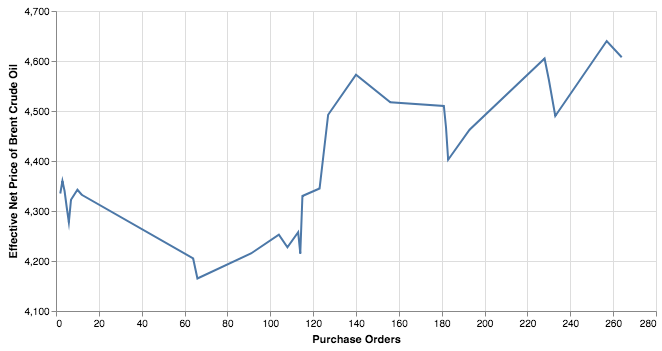

In [15]:
v_netpr = alt.Chart().mark_line().encode(
    x=alt.X('index', axis=alt.Axis(title='Purchase Orders')),
    y=alt.Y('NETPR', scale=alt.Scale(domain=(4100, 4700)), axis=alt.Axis(title='Effective Net Price of Brent Crude Oil'))
)
alt.layer(v_netpr, data = ekpo_bco.reset_index(), width=600, height=300)

**Reflect:** What is your interpretation of the effective net price?

## The volume of the Brent Crude Oil purchase orders

**Your task:** What is the average order volume for Brent Crude Oil?

In [16]:
ekpo_bco['MENGE'].mean()

19977.724137931036

**Your task:** Show how amount of all purchase orders (`MENGE`) of Brent Crude Oil. (We assume that the order of purchase orders represents time).

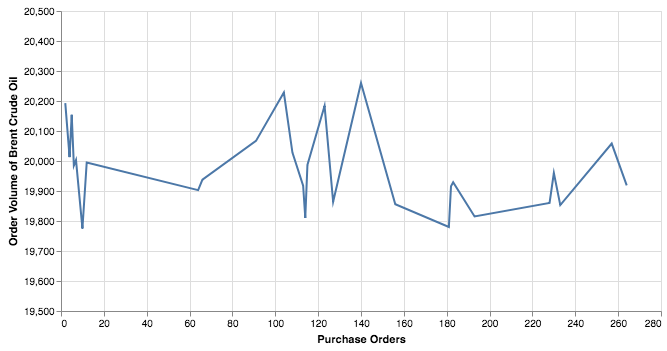

In [17]:
v_menge = alt.Chart().mark_line().encode(
    x=alt.X('index', axis=alt.Axis(title='Purchase Orders')),
    y=alt.Y('MENGE', scale=alt.Scale(domain=(19500, 20500)), axis=alt.Axis(title='Order Volume of Brent Crude Oil'))
)
alt.layer(v_menge, data = ekpo_bco.reset_index(), width=600, height=300)

**Reflect:** What is your interpretation of the order volume?

## Integrated analysis of `EKKO` and `EKPO`

**Your task:** Left join the `ekpo_bco` and the `ekko` tables. Store the result in a variable called `ekko_ekpo_bco`.

In [18]:
ekko_ekpo_bco = pd.merge(ekpo_bco, ekko, on='EBELN')

**Your task:** Show a sample of the `ekko_ekpo_bco` table.

In [19]:
ekko_ekpo_bco.sample(10)

,EBELN,EBELP,TXZ01,MATNR,MENGE,NETPR,NETWR,ERNAM,LIFNR,KNUMV
26,4500000225,10,Brent Crude Oil,BRENTCRUDE,19853,4490,89139970,GBIFAC-01,125000,1000000252
23,4500000185,10,Brent Crude Oil,BRENTCRUDE,19815,4462,88424438,GBIFAC-01,125000,1000000202
1,4500000002,10,Brent Crude Oil,BRENTCRUDE,20103,4360,87649080,GBI-085,125000,1000000021
10,4500000085,10,Brent Crude Oil,BRENTCRUDE,20067,4215,84582405,GBIFAC-01,125000,1000000104
16,4500000116,10,Brent Crude Oil,BRENTCRUDE,20184,4345,87699480,GBI-085,125000,1000000128
8,4500000061,10,Brent Crude Oil,BRENTCRUDE,19903,4205,83692115,GBIFAC-01,125000,1000000080
22,4500000175,10,Brent Crude Oil,BRENTCRUDE,19929,4402,87737422,GBIFAC-01,125000,1000000192
24,4500000220,10,Brent Crude Oil,BRENTCRUDE,19860,4605,91455300,GBIFAC-01,125000,1000000241
14,4500000107,10,Brent Crude Oil,BRENTCRUDE,19810,4215,83499150,GBIFAC-01,125000,1000000126
7,4500000011,10,Brent Crude Oil,BRENTCRUDE,19995,4332,86628338,GBIFAC-01,125000,1000000030


**Your task:** How many vendors (`LIFNR`) deliver Brent Crude Oil?

In [20]:
ekko_ekpo_bco['LIFNR'].unique()

array([125000.])

**Your task:** How many purchase group employees (`ERNAM`) are responsible for ordering Brent Crude Oil?

In [21]:
ekko_ekpo_bco['ERNAM'].unique()

array(['GBI-085', 'GBIFAC-01'], dtype=object)

**Your task:** Are there any differences in the average order volume between the purchase group employees (`ERNAM`)?

In [22]:
ekko_ekpo_bco.groupby('ERNAM')['MENGE'].mean()

ERNAM
GBI-085     20119
GBIFAC-01   19914
Name: MENGE, dtype: float64

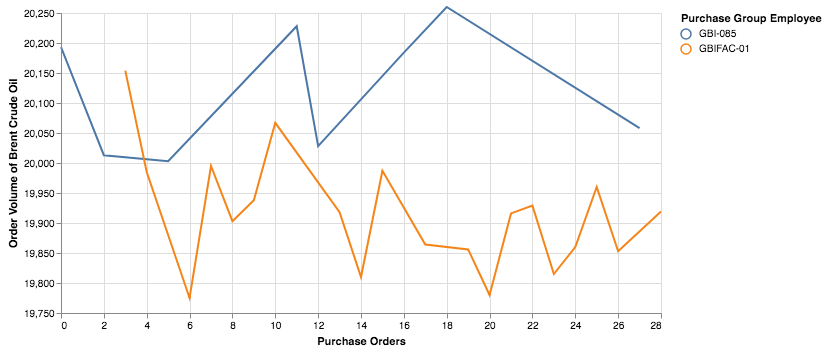

In [23]:
base = alt.Chart().mark_line().encode(
    x=alt.X('index', axis=alt.Axis(title='Purchase Orders')),
    y=alt.Y('MENGE', scale=alt.Scale(domain=(19760, 20250)), axis=alt.Axis(title='Order Volume of Brent Crude Oil')),
    color=alt.Color('ERNAM', legend=alt.Legend(title="Purchase Group Employee"))
)
alt.layer(base, data = ekko_ekpo_bco.reset_index(), width=600, height=300)

## Analysis of the Conditions

**Your task:** Filter the conditions for the purchase order of Brent Crude Oil? Store the result in a variable called `konv_bco`.

In [24]:
konv_bco = konv[konv['KNUMV'].isin(ekko_ekpo_bco['KNUMV'])]

**Your task:** Show the first five rows of `konv_bco`.

In [25]:
konv_bco.head()

,KNUMV,KPOSN,STUNR,KSCHL,KAWRT,KBETR
52,1000000020,10,1,PBXX,1000,4336
53,1000000020,10,11,RB00,87561655,-25000
54,1000000020,10,21,NAVM,87536655,0
55,1000000020,10,35,SKTO,87536655,0
56,1000000020,10,60,WOTB,1000,4335


**Your task:** What is the interesting condition type?

In [26]:
konv_bco.groupby('KSCHL')[['KSCHL']].count()

,KSCHL
KSCHL,
NAVM,29
PBXX,29
RB00,11
SKTO,29
WOTB,29


**Your task:** Add dummies for the condition type to `konv_bco`. Store the result in a variable called `konv_bco_d`?

In [27]:
konv_bco_d = konv_bco.join(konv_bco['KSCHL'].str.get_dummies())

**Your task:** Show the first five rows of `konv_bco_d`.

In [28]:
konv_bco_d.head()

,KNUMV,KPOSN,STUNR,KSCHL,KAWRT,KBETR,NAVM,PBXX,RB00,SKTO,WOTB
52,1000000020,10,1,PBXX,1000,4336,0,1,0,0,0
53,1000000020,10,11,RB00,87561655,-25000,0,0,1,0,0
54,1000000020,10,21,NAVM,87536655,0,1,0,0,0,0
55,1000000020,10,35,SKTO,87536655,0,0,0,0,1,0
56,1000000020,10,60,WOTB,1000,4335,0,0,0,0,1


**Your task:** Filter the sets of conditions that contain the condition type of interest. Store the result in a variable called by the name of the condition type.

In [29]:
rb00 = konv_bco_d.groupby('KNUMV')['RB00'].sum().reset_index()

**Your task:** Left join the condition type of interest to the other tables. Store the result in a variable called `eek_bco`.

In [30]:
eek_bco = pd.merge(ekko_ekpo_bco, rb00, on='KNUMV', how='left')

## What is the fraud?

**Your task:** What does the fraudster exploit?

In [31]:
eek_bco[eek_bco['RB00']==1]['MENGE'].min()
eek_bco[eek_bco['RB00']==1]['MENGE'].max()

20003

20260

In [32]:
eek_bco[eek_bco['RB00']==0]['MENGE'].min()
eek_bco[eek_bco['RB00']==0]['MENGE'].max()

19775

19995

**Your task:** Who is the person of interest?

In [33]:
eek_bco.groupby('RB00')[['MENGE', 'ERNAM']].agg({'MENGE': 'mean', 'ERNAM':'unique'})

,MENGE,ERNAM
RB00,,
0,19892,[GBIFAC-01]
1,20117,"[GBI-085, GBIFAC-01]"


**Your task:** What is the financial damage?

In [34]:
abs((len(ekko_ekpo_bco) - len(konv_bco[konv_bco['KSCHL']=='RB00'])) *\
konv_bco[konv_bco['KSCHL']=='RB00']['KBETR'].unique()[0])

450000.0

**Reflect:** Can you explain the fraud?